In [ ]:
!gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
From (redirected): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP&confirm=t&uuid=9e1d2480-e29e-4485-8f8e-a933c5e6ddac
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 44.1MB/s]


## Unzip Data

In [ ]:
!unzip /content/FER-2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

## Load and process image datas

### Process data use TFData

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
batch_size = 256
img_height = 180
img_width = 180
image_count = 28709
train_dir = "/content/train"
val_dir = "/content/test"

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, img_dir, norm):
    self.resize = Resize((img_height, img_width))
    self.norm = norm
    self.img_dir = img_dir
    self.classes = os.listdir(img_dir)
    self.image_files = [(os.path.join(cls, img), cls) for cls in self.classes for img in os.listdir(os.path.join(img_dir, cls))]
    self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
    self.idx_to_class = {idx:cls for cls, idx in self.class_to_idx.items()}

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_path, cls = self.image_files[idx]
    image = self.resize(read_image(os.path.join(self.img_dir, img_path)))
    image = image.type(torch.float32)
    label = self.class_to_idx[cls]
    if self.norm:
      image = (image/127.5) - 1
    return image, label

In [ ]:
train_dataset = ImageDataset(train_dir, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(val_dir, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

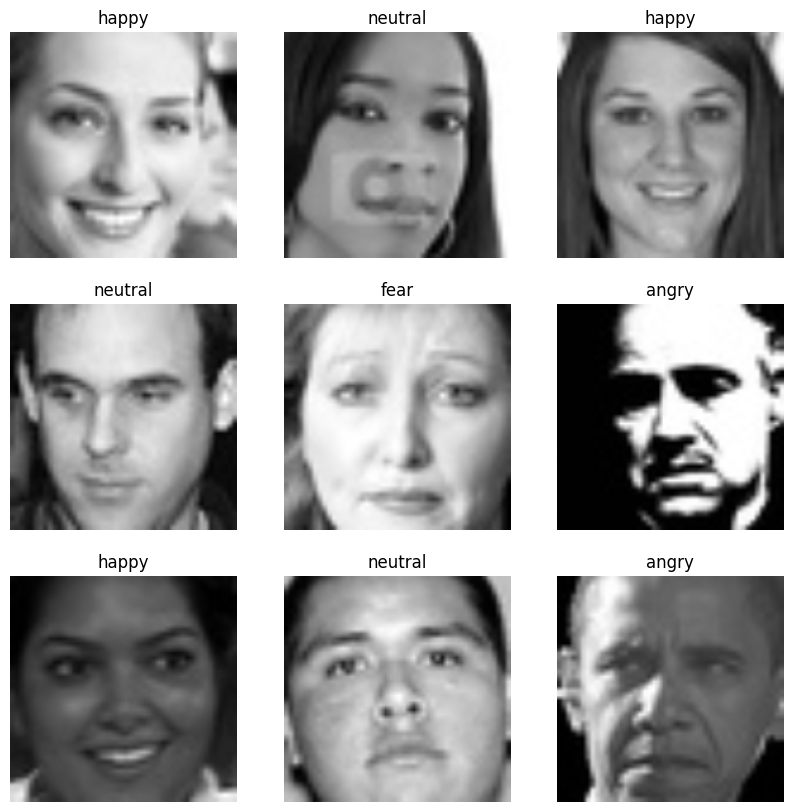

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(train_dataset.idx_to_class[label.item()])
  plt.axis("off")

In [ ]:
######################### YOUR CODE HERE #########################
# Thiết kế model theo yêu cầu đề  bài
# Linear layer in_features = input_dims (180*180), out_features = num_classes (7)

class SoftMaxRegression(nn.Module):
    def __init__(self, input_dims, num_classes):
      super(SoftMaxRegression, self).__init__()
      self.linear = nn.Linear(input_dims, num_classes)

    def forward(self, x):
      x = nn.Flatten()(x)
      out = self.linear(x)
      return out
##################################################################

model = SoftMaxRegression(input_dims=180*180, num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006)

In [17]:
num_epochs = 100
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    accuracy = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy /= cnt
    train_acc.append(accuracy)


    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    cnt = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_accuracy += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy /= cnt
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Train_Acc: {accuracy:.4f}, Val_Loss: {val_loss:.4f},  Val_Acc: {val_accuracy:.4f}")

Epoch 1/100, Train_Loss: 1171845.3280,  Train_Acc: 0.1825, Val_Loss: 1620075.1388,  Val_Acc: 0.1513
Epoch 2/100, Train_Loss: 1080738.8243,  Train_Acc: 0.1913, Val_Loss: 990537.8826,  Val_Acc: 0.1560
Epoch 3/100, Train_Loss: 1040052.8537,  Train_Acc: 0.1976, Val_Loss: 855163.1877,  Val_Acc: 0.1294
Epoch 4/100, Train_Loss: 913535.4920,  Train_Acc: 0.2075, Val_Loss: 1083154.2668,  Val_Acc: 0.1772
Epoch 5/100, Train_Loss: 953654.3681,  Train_Acc: 0.2113, Val_Loss: 1235762.2296,  Val_Acc: 0.2569
Epoch 6/100, Train_Loss: 873848.2699,  Train_Acc: 0.2186, Val_Loss: 539579.9230,  Val_Acc: 0.3001
Epoch 7/100, Train_Loss: 870108.9759,  Train_Acc: 0.2219, Val_Loss: 730672.3282,  Val_Acc: 0.1971
Epoch 8/100, Train_Loss: 840960.1341,  Train_Acc: 0.2234, Val_Loss: 773046.7103,  Val_Acc: 0.2136
Epoch 9/100, Train_Loss: 850878.6731,  Train_Acc: 0.2256, Val_Loss: 604351.5191,  Val_Acc: 0.2087
Epoch 10/100, Train_Loss: 773875.7916,  Train_Acc: 0.2300, Val_Loss: 595008.6098,  Val_Acc: 0.2778
Epoch 11/100,

In [18]:
train_loss


698767.1189159292

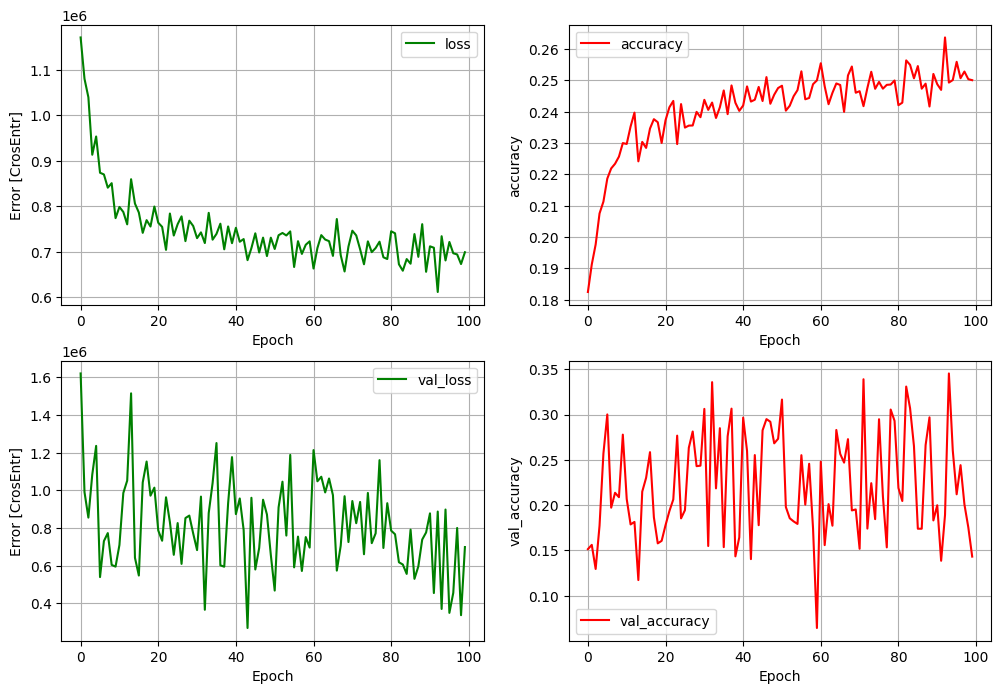

In [19]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_acc, label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_acc, label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)
